# Exploratory Data Analisys

Challenge: https://www.kaggle.com/competitions/playground-series-s3e17/overview/evaluation

Dataset info: [https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions](https://www.kaggle.com/datasets/dineshmanikanta/machine-failure-predictions)

### Columns meaning

**Type**: consisting of a letter L, M, or H for low, medium and high as product quality variants.

**air temperature [K]**: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K.

**process temperature [K]**: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.

**rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise.

**torque [Nm]**: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.

**tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

**machine failure**: whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes

**tool wear failure (TWF)**: the tool will be replaced of fail at a randomly selected tool wear time between 200 ~ 240 mins.

**heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm.

**power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.

**overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.

**random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process parameters.

In [1]:
from typing import Dict, List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
project_path = "/home/ninja/Dropbox/ml/kaggle/machine_failure"
target_name = "Machine failure"
summary = {}

In [3]:
def update_summary(comment: str, col: str, summary = summary) -> Dict:
    '''Function to track strategies to apply to columns in data preprocessing phase.'''
    if col not in summary.keys():
        summary[col] = []
    summary[col].append(comment)
    
    return summary

def update_summary_one2n(comment: str, cols: List, summary = summary) -> Dict:
    '''Use `update_summary` to add the same comment to a list of columns.'''
    for col in cols:
        summary = update_summary(comment, col, summary = summary)
    
    return summary

def update_summary_n2n(comments: List, cols: List, summary = summary) -> Dict:
    '''Use `update_summary` to add `n` comments to `n` columns.'''
    for comment,col in zip(comments,cols):
        summary = update_summary(comment, col, summary = summary)
    
    return summary

def update_summary_n2one(comments: List, col: str, summary = summary) -> Dict:
    '''Use `update_summary` to add `n` comments to a column.'''
    for comment in comments:
        summary = update_summary(comment, col, summary = summary)
    
    return summary

In [4]:
df = pd.read_csv(f"{project_path}/data/train.csv")
test_df = pd.read_csv(f"{project_path}/data/test.csv")

Vamos unir os dois datasets e criar uma coluna extra para identificar as observações de cada um.

In [5]:
df.shape, test_df.shape

((136429, 14), (90954, 13))

O dataset de test não tem a coluna de rótulo.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136429 entries, 0 to 136428
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   id                       136429 non-null  int64  
 1   Product ID               136429 non-null  object 
 2   Type                     136429 non-null  object 
 3   Air temperature [K]      136429 non-null  float64
 4   Process temperature [K]  136429 non-null  float64
 5   Rotational speed [rpm]   136429 non-null  int64  
 6   Torque [Nm]              136429 non-null  float64
 7   Tool wear [min]          136429 non-null  int64  
 8   Machine failure          136429 non-null  int64  
 9   TWF                      136429 non-null  int64  
 10  HDF                      136429 non-null  int64  
 11  PWF                      136429 non-null  int64  
 12  OSF                      136429 non-null  int64  
 13  RNF                      136429 non-null  int64  
dtypes: f

In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90954 entries, 0 to 90953
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       90954 non-null  int64  
 1   Product ID               90954 non-null  object 
 2   Type                     90954 non-null  object 
 3   Air temperature [K]      90954 non-null  float64
 4   Process temperature [K]  90954 non-null  float64
 5   Rotational speed [rpm]   90954 non-null  int64  
 6   Torque [Nm]              90954 non-null  float64
 7   Tool wear [min]          90954 non-null  int64  
 8   TWF                      90954 non-null  int64  
 9   HDF                      90954 non-null  int64  
 10  PWF                      90954 non-null  int64  
 11  OSF                      90954 non-null  int64  
 12  RNF                      90954 non-null  int64  
dtypes: float64(3), int64(8), object(2)
memory usage: 9.0+ MB


In [8]:
summary = update_summary_one2n("No missing data", df.columns, summary)

In [9]:
summary

{'id': ['No missing data'],
 'Product ID': ['No missing data'],
 'Type': ['No missing data'],
 'Air temperature [K]': ['No missing data'],
 'Process temperature [K]': ['No missing data'],
 'Rotational speed [rpm]': ['No missing data'],
 'Torque [Nm]': ['No missing data'],
 'Tool wear [min]': ['No missing data'],
 'Machine failure': ['No missing data'],
 'TWF': ['No missing data'],
 'HDF': ['No missing data'],
 'PWF': ['No missing data'],
 'OSF': ['No missing data'],
 'RNF': ['No missing data']}

### Separar tipos de colunas

In [5]:
def split_cols_by_type(df: pd.DataFrame) -> Dict:
    cols = df.columns.tolist()
    cols_types = {
        "str_cols":[],
        "int_cols":[],
        "float_cols":[]
    }
    for col in cols:
        if isinstance(df[col][0],str):
            cols_types['str_cols'].append(col)
        elif isinstance(df[col][0],np.int64):
            cols_types['int_cols'].append(col)
        elif isinstance(df[col][0],np.float64):
            cols_types['float_cols'].append(col)
    
    return cols_types

def print_cols_by_types(x: Dict):
    for item in (cols_types.items()):
        print(f"{item[0]}: {item[1]}")

In [6]:
cols_types = split_cols_by_type(df)
print_cols_by_types(cols_types)

str_cols: ['Product ID', 'Type']
int_cols: ['id', 'Rotational speed [rpm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
float_cols: ['Air temperature [K]', 'Process temperature [K]', 'Torque [Nm]']


### Verificar colunas tipo string

- **Type**: consisting of a letter L, M, or H for low, medium and high as product quality variants.
- **Product ID**: identification code of each product.

In [7]:
from IPython.display import display

In [8]:
display(df[['Type']].value_counts())

display(df[['Type']].value_counts(normalize=True))

Type
L       95354
M       32152
H        8923
dtype: int64

Type
L       0.698928
M       0.235668
H       0.065404
dtype: float64

In [9]:
summary = update_summary_n2one(
    [
        ["Unbalanced categorical feature: apply stratification during split_train_test"],
        ["Apply one hot encoding"]
    ],
    "Type"
)

Q: Há produtos repetidos?

In [17]:
df[['Product ID']].head(2)

,Product ID
0,L50096
1,M20343


In [31]:
display(df[['Product ID']].value_counts().reset_index())

,Product ID,0
0,L53257,139
1,L53271,131
2,L49056,131
3,L48892,120
4,L54275,120
...,...,...
9971,M18364,1
9972,M18491,1
9973,M18670,1
9974,M18727,1


A: Sim. Alguns produtos aparecem mais vezes e isso pode criar viés no número de falhas.

In [29]:
aux_df = df[['Product ID',target_name]].groupby(by='Product ID').sum().reset_index()
aux_df = aux_df.sort_values(by=target_name, ascending=False)

In [40]:
aux_df

,Product ID,Machine failure
4645,L53258,19
2256,L49305,12
5245,L54263,11
5295,L54347,11
6117,L55686,11
...,...,...
3398,L51200,0
3397,L51197,0
3396,L51196,0
3395,L51195,0


In [41]:
aux_df[aux_df['Machine failure']==0].shape[0],aux_df[aux_df['Machine failure']==0].shape[0]/aux_df.shape[0]

(8663, 0.8683841218925421)

In [48]:
aux_df = pd.merge(left = aux_df,
                  right = df[['Product ID']].value_counts().reset_index(),
                  on = 'Product ID',
                  how = 'inner'
                 )
aux_df = aux_df.rename(columns = {0 : 'product_count'})

In [52]:
aux_df['failure_fraction'] = aux_df['Machine failure'] / aux_df['product_count']

In [53]:
aux_df

,Product ID,Machine failure,product_count,failure_fraction
0,L53258,19,117,0.162393
1,L49305,12,19,0.631579
2,L54263,11,49,0.224490
3,L54347,11,21,0.523810
4,L55686,11,22,0.500000
...,...,...,...,...
9971,L51200,0,12,0.000000
9972,L51197,0,5,0.000000
9973,L51196,0,5,0.000000
9974,L51195,0,4,0.000000


<Axes: xlabel='product_count', ylabel='Machine failure'>

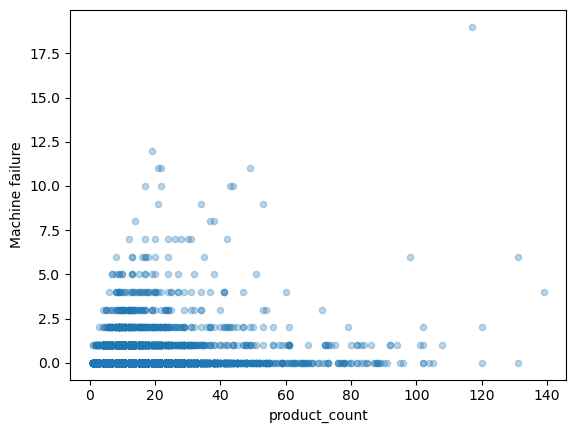

In [55]:
aux_df.plot(kind='scatter', x='product_count', y='Machine failure', alpha=0.3)

Q: Existe algum padrão no nome das máquinas que possa ser útil?

In [117]:
df[['Product ID','Type']].head(10)

,Product ID,Type
0,L50096,L
1,M20343,M
2,L49454,L
3,L53355,L
4,M24050,M
5,M24300,M
6,L56736,L
7,L55488,L
8,L56397,L
9,L55067,L


In [120]:
aux_df = df[['Product ID','Type'] + [target_name]].copy()
aux_df['prod_first_letter'] = aux_df['Product ID'].apply(lambda x: x[0])
aux_df['prod_numeric_code'] = aux_df['Product ID'].apply(lambda x: int(x[1:]))

In [121]:
aux_df[aux_df['prod_first_letter'] == aux_df['Type']].shape[0] / aux_df.shape[0]

1.0

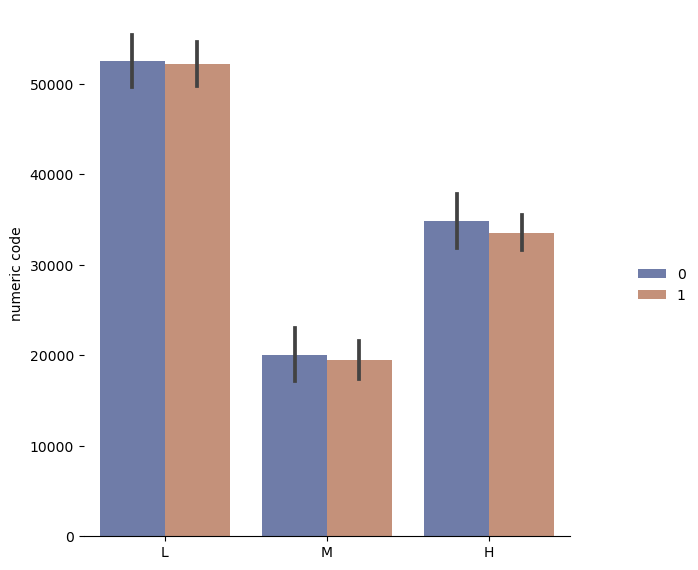

In [123]:
g = sns.catplot(
    data=aux_df, kind="bar",
    x="Type", y="prod_numeric_code", hue=target_name,
    errorbar="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("", "numeric code")
g.legend.set_title("")

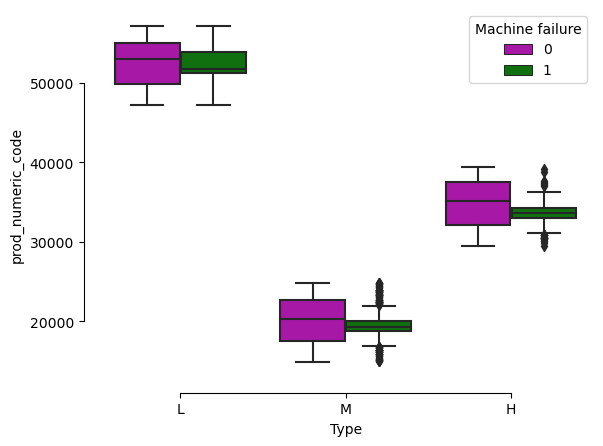

In [124]:
sns.boxplot(x="Type", y="prod_numeric_code",
            hue=target_name, palette=["m", "g"],
            data=aux_df)
sns.despine(offset=10, trim=True)

In [127]:
aux_df.groupby(by=['Machine failure', 'Type'])['prod_numeric_code'].mean()

Machine failure  Type
0                H       34836.864994
                 L       52491.813650
                 M       20065.376383
1                H       33553.508621
                 L       52202.663323
                 M       19480.352403
Name: prod_numeric_code, dtype: float64

In [128]:
aux_df.groupby(by=['Machine failure', 'Type'])['prod_numeric_code'].std()

Machine failure  Type
0                H       3024.408875
                 L       2919.416179
                 M       2908.938830
1                H       1913.248594
                 L       2445.069340
                 M       2076.261926
Name: prod_numeric_code, dtype: float64

In [129]:
for i in aux_df['Type'].unique().tolist():
    positive_mean = aux_df[(aux_df[target_name]==1)&(aux_df['Type']==i)]['prod_numeric_code'].mean()
    negative_mean = aux_df[(aux_df[target_name]==0)&(aux_df['Type']==i)]['prod_numeric_code'].mean()
    print(f"{i} diff: {(positive_mean-negative_mean)}")

L diff: -289.15032700559823
M diff: -585.0239806687896
H diff: -1283.3563730653186


A primeira letra coincide com o `Type`, enquanto o código numérico que vem a seguir parece seguir um padrão relacionado ao tipo também. Entretanto, os produtos com falha costumam ter uma média menor desse número. Podemos fazer um teste de hipótese para ver se detectamos diferença entre as médias dos produtos com e sem falhas. Vamos deixar isso de lado por enquanto e voltar a isso em um segundo estágio de melhoria da modelagem.

### Verificar colunas tipo int

- **rotational speed [rpm]**: calculated from a power of 2860 W, overlaid with a normally distributed noise.
- **tool wear [min]**: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.
- **machine failure**: whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes:

- **tool wear failure (TWF)**: the tool will be replaced of fail at a randomly selected tool wear time between 200 ~ 240 mins.
- **heat dissipation failure (HDF)**: heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the rotational speed is below 1380 rpm.
- **power failure (PWF)**: the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails.
- **overstrain failure (OSF)**: if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain.
- **random failures (RNF)**: each process has a chance of 0,1 % to fail regardless of its process parameters.

In [16]:
df[cols_types['int_cols']].head(5)

,id,Rotational speed [rpm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,1596,140,0,0,0,0,0,0
1,1,1759,200,0,0,0,0,0,0
2,2,1805,25,0,0,0,0,0,0
3,3,1524,197,0,0,0,0,0,0
4,4,1641,34,0,0,0,0,0,0


In [92]:
df[cols_types['int_cols']].describe()

,id,Machine failure,TWF,HDF,PWF,OSF,RNF
count,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000,136429.000000
mean,68214.000000,0.015744,0.001554,0.005160,0.002397,0.003958,0.002258
std,39383.804275,0.124486,0.039389,0.071649,0.048899,0.062789,0.047461
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,34107.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68214.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,102321.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,136428.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


As features `'Rotational speed [rpm]', 'Tool wear [min]'` vamos tratar como números reais. A coluna `id` é apenas o índice do dataframe e pode ser descartado.

In [ ]:
df.describe()

In [10]:
for col in ['Rotational speed [rpm]', 'Tool wear [min]']:
    cols_types['int_cols'].remove(col)
    cols_types['float_cols'].append(col)

In [11]:
summary = update_summary_one2n(
    "Transform in float",
    ['Rotational speed [rpm]', 'Tool wear [min]']
)

summary = update_summary("Drop", "id")

In [12]:
for col in cols_types['int_cols'][-5:]:
    display(df[col].value_counts())

0    136217
1       212
Name: TWF, dtype: int64

0    135725
1       704
Name: HDF, dtype: int64

0    136102
1       327
Name: PWF, dtype: int64

0    135889
1       540
Name: OSF, dtype: int64

0    136121
1       308
Name: RNF, dtype: int64

Todas essas falhas são binárias.
Q: Como essas variáveis se comportam com o rótulo?

In [58]:
for col in cols_types['int_cols'][-5:]:
    print(f"{col}: {df[df[col]==1][target_name].sum() / df[df[col]==1].shape[0]}")

TWF: 1.0
HDF: 0.9914772727272727
PWF: 0.9908256880733946
OSF: 0.9925925925925926
RNF: 0.01948051948051948


In [59]:
for col in cols_types['int_cols'][-5:]:
    print(f"{col}: {df[df[target_name]==1][col].sum() / df[df[target_name]==1].shape[0]}")

TWF: 0.09869646182495345
HDF: 0.3249534450651769
PWF: 0.15083798882681565
OSF: 0.24953445065176907
RNF: 0.002793296089385475


In [66]:
df[
    (df['TWF']==1)|
    (df['HDF']==1)|
    (df['PWF']==1)|
    (df['OSF']==1)|
    (df['RNF']==1)
].shape[0]/df[df[target_name]==1].shape[0]

0.9106145251396648

In [18]:
test_df

,id,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF
0,136429,L50896,L,302.3,311.5,1499,38.0,60,0,0,0,0,0
1,136430,L53866,L,301.7,311.0,1713,28.8,17,0,0,0,0,0
2,136431,L50498,L,301.3,310.4,1525,37.7,96,0,0,0,0,0
3,136432,M21232,M,300.1,309.6,1479,47.6,5,0,0,0,0,0
4,136433,M19751,M,303.4,312.3,1515,41.3,114,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90949,227378,L51130,L,302.3,311.4,1484,40.4,15,0,0,0,0,0
90950,227379,L47783,L,297.9,309.8,1542,33.8,31,0,0,0,0,0
90951,227380,L48097,L,295.6,306.2,1501,41.4,187,0,0,0,0,0
90952,227381,L48969,L,298.1,307.8,1534,40.3,69,0,0,0,0,0


In [68]:
df[
    (df['TWF']==1)|
    (df['HDF']==1)|
    (df['PWF']==1)|
    (df['OSF']==1)|
    (df['RNF']==1)
][target_name].sum() / df[df[target_name]==1].shape[0]

0.7639664804469274

A: Parece que todas as falhas deveriam se encaixar em alguma dessas categorias. Esses dados poderiam ser usados tb como rótulos para predizer qual é o tipo provável de falha. Como queremos apenas predizer a falha e não seu tipo, vamos descartar essas colunas.

In [93]:
df[['Rotational speed [rpm]', 'Tool wear [min]']].describe(percentiles=[0.10, .25, .5, .75, 0.90])

,Rotational speed [rpm],Tool wear [min]
count,136429.000000,136429.000000
mean,1520.331110,104.408901
std,138.736632,63.965040
min,1181.000000,0.000000
10%,1378.000000,14.000000
25%,1432.000000,48.000000
50%,1493.000000,106.000000
75%,1580.000000,159.000000
90%,1686.000000,192.000000
max,2886.000000,253.000000


Pode ser útil aplicar alguma transformação em `'Rotational speed [rpm]'`

In [22]:
from sklearn.preprocessing import StandardScaler

scl = StandardScaler()

In [ ]:
aux_df = df[['Rotational speed [rpm]', 'Tool wear [min]', 'Machine failure']].sample(3000).reset_index(drop=True)
aux_df['norm Rotational speed [rpm]'] = scl.fit_transform(aux_df[['Rotational speed [rpm]']])
aux_df['norm Tool wear [min]'] = scl.fit_transform(aux_df[['Tool wear [min]']])
# aux_df['log Rotational speed [rpm]'] = np.log(aux_df['Rotational speed [rpm]'])
g = sns.PairGrid(aux_df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

<Axes: xlabel='log Rotational speed [rpm]', ylabel='Tool wear [min]'>

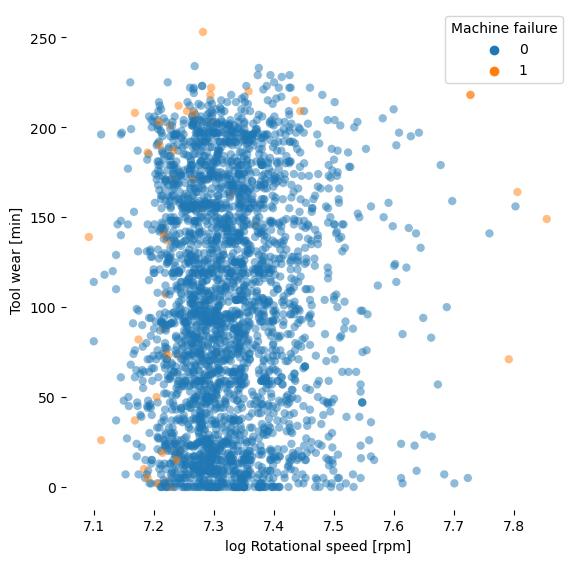

In [107]:
aux_df = df[['Rotational speed [rpm]', 'Tool wear [min]', 'Machine failure']].sample(3000)
aux_df['log Rotational speed [rpm]'] = np.log(aux_df['Rotational speed [rpm]'])
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x='log Rotational speed [rpm]', y='Tool wear [min]',
                hue='Machine failure',
                hue_order=[0,1],
                sizes=(1, 8), linewidth=0,
                data=aux_df, ax=ax, alpha=0.5)

### Verificar colunas tipo float

In [13]:
cols_types['float_cols']

['Air temperature [K]',
 'Process temperature [K]',
 'Torque [Nm]',
 'Rotational speed [rpm]',
 'Tool wear [min]']

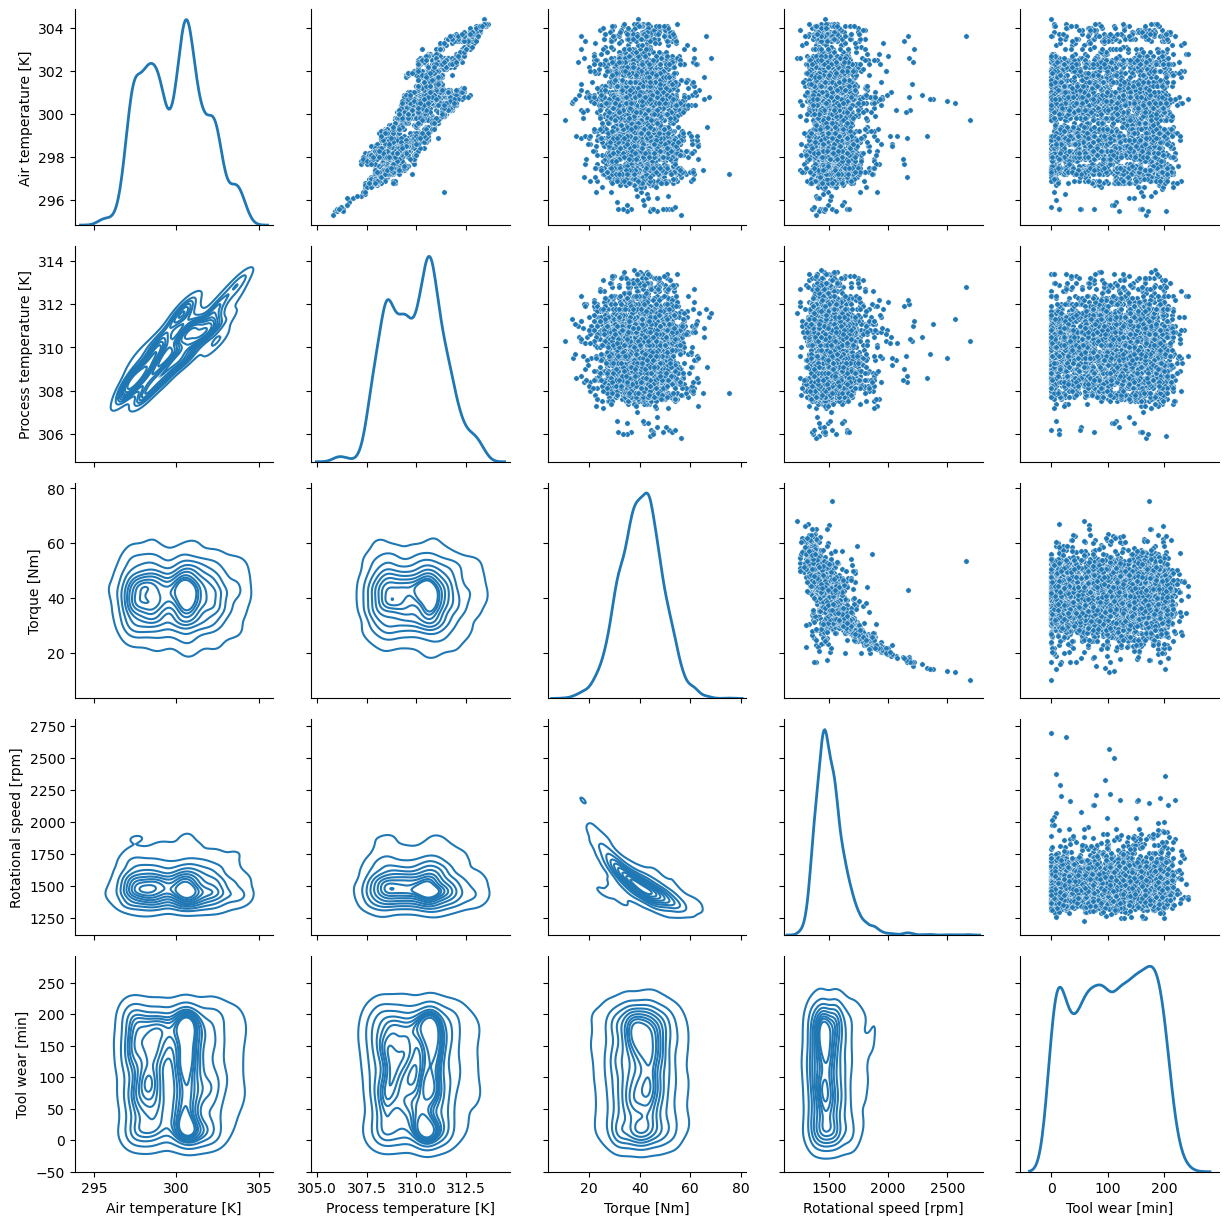

In [111]:
aux_df = df[cols_types['float_cols']].sample(3000).reset_index(drop=True)
# aux_df['norm Rotational speed [rpm]'] = scl.fit_transform(aux_df[['Rotational speed [rpm]']])
# aux_df['norm Tool wear [min]'] = scl.fit_transform(aux_df[['Tool wear [min]']])
# aux_df['log Rotational speed [rpm]'] = np.log(aux_df['Rotational speed [rpm]'])
g = sns.PairGrid(aux_df, diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

As distribuições estão razoavelmente normais, menos `Tool wear [min]`.

### Aplicar transformações e comparar features com o rótulo

In [14]:
cols_types['float_cols'], cols_types['str_cols']

(['Air temperature [K]',
  'Process temperature [K]',
  'Torque [Nm]',
  'Rotational speed [rpm]',
  'Tool wear [min]'],
 ['Product ID', 'Type'])

In [15]:
aux_df = pd.concat([
    df.drop(['id','Product ID', 'Type'],axis=1),
    pd.get_dummies(df['Type'],prefix='type')
],axis=1)
# 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'
aux_test_df = pd.concat([
    test_df.drop(['id','Product ID', 'Type',],axis=1),
    pd.get_dummies(test_df['Type'],prefix='type')
],axis=1)

In [16]:
aux_df.head(3)

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,type_H,type_L,type_M
0,300.6,309.6,1596,36.1,140,0,0,0,0,0,0,0,1,0
1,302.6,312.1,1759,29.1,200,0,0,0,0,0,0,0,0,1
2,299.3,308.5,1805,26.5,25,0,0,0,0,0,0,0,1,0


In [17]:
corr = aux_df.corr('spearman')

In [18]:
corr.sort_values(target_name)[target_name]

Rotational speed [rpm]    -0.122225
type_M                    -0.009603
type_H                    -0.005832
RNF                        0.001428
type_L                     0.012028
Process temperature [K]    0.032845
Tool wear [min]            0.055243
Air temperature [K]        0.066817
Torque [Nm]                0.122521
TWF                        0.311919
PWF                        0.383941
OSF                        0.494668
HDF                        0.564507
Machine failure            1.000000
Name: Machine failure, dtype: float64

In [19]:
aux_df = aux_df.drop('type_M',axis=1)
aux_test_df = aux_test_df.drop('type_M',axis=1)

In [20]:
aux_df.columns

Index(['Air temperature [K]', 'Process temperature [K]',
       'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'type_H',
       'type_L'],
      dtype='object')

In [23]:
scl = StandardScaler()
scl.fit(aux_df[
    ['Air temperature [K]',
     'Process temperature [K]',
     'Rotational speed [rpm]',
     'Torque [Nm]',
     'Tool wear [min]']
])

train_data = scl.transform(aux_df[
    ['Air temperature [K]',
     'Process temperature [K]',
     'Rotational speed [rpm]',
     'Torque [Nm]',
     'Tool wear [min]']
])

test_data = scl.transform(aux_test_df[
    ['Air temperature [K]',
     'Process temperature [K]',
     'Rotational speed [rpm]',
     'Torque [Nm]',
     'Tool wear [min]']
])

In [25]:
def create_data_df(df,transformed_data):
    data_df = pd.DataFrame(data = transformed_data, columns = [
        'Air temperature [K]',
        'Process temperature [K]',
        'Rotational speed [rpm]',
        'Torque [Nm]',
        'Tool wear [min]'])

    data_df = pd.concat([data_df,df[['TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'type_H', 'type_L']]], axis=1)
    
    return data_df

In [26]:
train_df = create_data_df(aux_df,train_data)
train_df = pd.concat([train_df,aux_df[target_name]], axis=1)
val_df = create_data_df(aux_test_df,test_data)

In [27]:
train_df.to_csv(f"{project_path}/data/processed_train_extra.csv",index=False)
val_df.to_csv(f"{project_path}/data/processed_test_extra.csv",index=False)

### Coisas para se tentar

- Construir um gerador de dados para inserir mais dados do rótulo pouco representativo
- Fazer data augmentation: downsampling do rótulo 0; ou oversampling do rótulo 1
- Construir um autoencoder para extração de dados
- Excluir as regiões em que só aparecem dados com o rótulo 0